<font size=6  color= 'blue' > <b>[LEPL1507] - PROJET P4</b> <br>
<br><br>
Airson Alexis<br>
Beniffou Ibrahim <br>
Henneaux Lucas <br>
Lemaire Antoine <br>
Smith Marielle <br>
Canon Théo<br>
<div style="text-align: right"> </div>

<br><br>
</font>


In [137]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import os
import tensorflow as tf
#import tensorflow_datasets as tfds

from tensorflow.keras import layers
import random
from sklearn.metrics import classification_report

In [138]:
#preprocessing of ppm dataset 
path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'
nbr_class = 62

DIR = path_training
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_train = counter

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = (30, 30),
batch_size = batch_size_train,class_mode = 'binary', color_mode='rgb')

DIR = path_testing
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_test = counter

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(path_testing,
target_size = (30, 30),batch_size = batch_size_test, class_mode = 'binary')


4575
Found 4575 images belonging to 62 classes.
2520
Found 2520 images belonging to 62 classes.


training_set = ensemble de 143 tuples
Chaque tuple représente 32 images (sauf le dernier, 31 images)

tuple[0] = features = tableau (32, 30, 30, 3)
tuple[1] = label = tableau (32)

plt.imshow(training_set[i][0][j]) affiche l'image n°j du paquet d'image n°i 

In [139]:
'''
On met toutes les données du Training Set dans un numpy array
'''

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
aug.fit(X_train)

(4575, 30, 30, 3)
(4575,)
(2520, 30, 30, 3)
(2520,)


In [140]:

'''
Augmentation de données :

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(64, 64, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image = data_augmentation(X_train[a:b])
augmented_image = data_augmentation(X_test[c:d])
==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris

idx = random.randint(a, b)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])

plt.subplot(1, 2, 2)
plt.imshow(augmented_image[idx])

'''

'\nAugmentation de données :\n\ndata_augmentation = tf.keras.Sequential(\n    [\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            "horizontal", input_shape=(64, 64, 3)),\n        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),\n        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            mode="horizontal_and_vertical")\n    ]\n)\n\naugmented_image = data_augmentation(X_train[a:b])\naugmented_image = data_augmentation(X_test[c:d])\n==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris\n\nidx = random.randint(a, b)\nplt.figure()\nplt.subplot(1, 2, 1)\nplt.imshow(X_train[idx])\n\nplt.subplot(1, 2, 2)\nplt.imshow(augmented_image[idx])\n\n'

In [141]:
y_train = to_categorical(y_train, nbr_class)
y_test = to_categorical(y_test, nbr_class)

print(y_train.shape)
print(y_test.shape)

(4575, 62)
(2520, 62)


In [143]:
'''
On construit le modèle de prédiction sur base de la méthode CNN
'''

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [144]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 26, 26, 32)        2432      
                                                                 
 conv2d_53 (Conv2D)          (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 7, 7, 64)          36928     
                                                     

In [145]:
'''
On entraîne le modèle de prédiction
'''

eps = 15
#mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(aug.flow(X_train, y_train), validation_data=(X_test, y_test), epochs=eps)
#added aug.flow to (X_train, y_train) to do data augmentation


Epoch 1/15
143/143 [==============================] - 13s 80ms/step - loss: 3.3163 - accuracy: 0.1823 - val_loss: 2.4740 - val_accuracy: 0.4222
Epoch 2/15
143/143 [==============================] - 11s 79ms/step - loss: 2.1893 - accuracy: 0.4197 - val_loss: 1.4975 - val_accuracy: 0.5968
Epoch 3/15
143/143 [==============================] - 12s 81ms/step - loss: 1.6612 - accuracy: 0.5314 - val_loss: 1.0457 - val_accuracy: 0.7306
Epoch 4/15
143/143 [==============================] - 11s 80ms/step - loss: 1.3767 - accuracy: 0.6009 - val_loss: 0.8147 - val_accuracy: 0.7488
Epoch 5/15
143/143 [==============================] - 11s 77ms/step - loss: 1.1718 - accuracy: 0.6505 - val_loss: 0.6788 - val_accuracy: 0.7579
Epoch 6/15
143/143 [==============================] - 11s 78ms/step - loss: 1.0727 - accuracy: 0.6815 - val_loss: 0.6117 - val_accuracy: 0.7937
Epoch 7/15
143/143 [==============================] - 11s 79ms/step - loss: 0.9225 - accuracy: 0.7139 - val_loss: 0.4646 - val_accuracy:

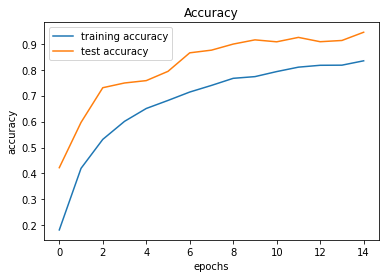

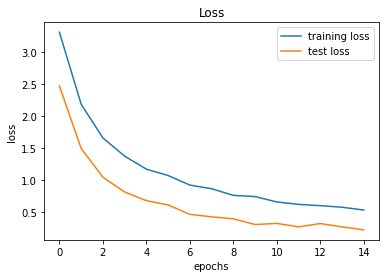

In [146]:
'''
On plot les résultats de performances
'''

plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [147]:
# evaluate the network
label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

print("[INFO] evaluating network...")
predictions = model.predict(X_test) 
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names, labels=range(61)))


[INFO] evaluating network...
79/79 [==============================] - 1s 16ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      0.67      0.80         6
                         "bump"       0.96      1.00      0.98        27
                     "slippery"       1.00      0.86      0.92         7
                   "left_curve"       0.00      0.00      0.00         6
                  "right_curve"       0.00      0.00      0.00        12
                  "left_curves"       1.00      0.67      0.80         3
                 "right_curves"       0.00      0.00      0.00         6
                     "children"       0.90      0.97      0.93        90
                      "cyclist"       0.42      0.92      0.58        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       0.88      1.00      0.93        28
              "traffic_signals"       0.

c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2326: UserWarning: labels size, 61, does not match size of target_names, 62
  warnings.warn(
c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: Und

A partir d'un ensemble de feature X_predict :

pred = model.predict_classes(X_predict)
print(accuracy_score(y_predict, pred))